#### Import modules

In [1]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd

### States

#### Read states data file

In [2]:
states_adj = {}

with open(os.getcwd() + '/Data/usa-state-data.json', 'r') as state_json:
    states_adj = json.load(state_json)
    
len(states_adj)

51

In [3]:
# states_adj

#### Create states code and name maps

In [4]:
code_to_name, name_to_code = {}, {}

for code in states_adj:
    name = states_adj[code]['name']
    code_to_name[code] = name
    name_to_code[name] = code
    
code_to_name['MA'], name_to_code['Massachusetts']

('Massachusetts', 'MA')

#### Create network of states

In [5]:
ignore_states = ()

state_cons = []

for s in states_adj:
    if s not in ignore_states:
        for n in states_adj[s]['adjacent']:  # lists for AK and HI are empty, hence this loop is not run for them
            state_cons.append([s, n, states_adj[s]['region'], states_adj[n]['region']])

In [6]:
# state_cons

In [7]:
states_edge_pairs = pd.DataFrame(state_cons, columns = ['state1', 'state2', 'state1_region', 'state2_region'])
states_edge_pairs['same_region'] = states_edge_pairs['state1_region'] == states_edge_pairs['state2_region'] 
states_edge_pairs.head()

,state1,state2,state1_region,state2_region,same_region
0,AL,FL,South,South,True
1,AL,GA,South,South,True
2,AL,TN,South,South,True
3,AL,MS,South,South,True
4,AZ,NM,West,West,True


In [8]:
states_regions = states_edge_pairs[['state1', 'state1_region']].drop_duplicates().set_index('state1')
states_regions.head()

,state1_region
state1,
AL,South
AZ,West
AR,South
CA,West
CO,West


In [9]:
states_graph = nx.from_pandas_edgelist(states_edge_pairs, 'state1', 'state2', ['same_region'])
nx.set_node_attributes(states_graph, values = states_regions['state1_region'].to_dict(), name = 'Region')

In [10]:
states_graph.nodes['MA']['Region']

'Northeast'

In [11]:
states_graph['MA']

AtlasView({'CT': {'same_region': True}, 'NH': {'same_region': True}, 'VT': {'same_region': True}, 'NY': {'same_region': True}, 'RI': {'same_region': True}})

In [12]:
states_graph.number_of_nodes(), states_graph.number_of_edges()

(49, 107)

In [13]:
nx.write_gml(states_graph, os.getcwd() + '/Graphs/states_graph.gml')

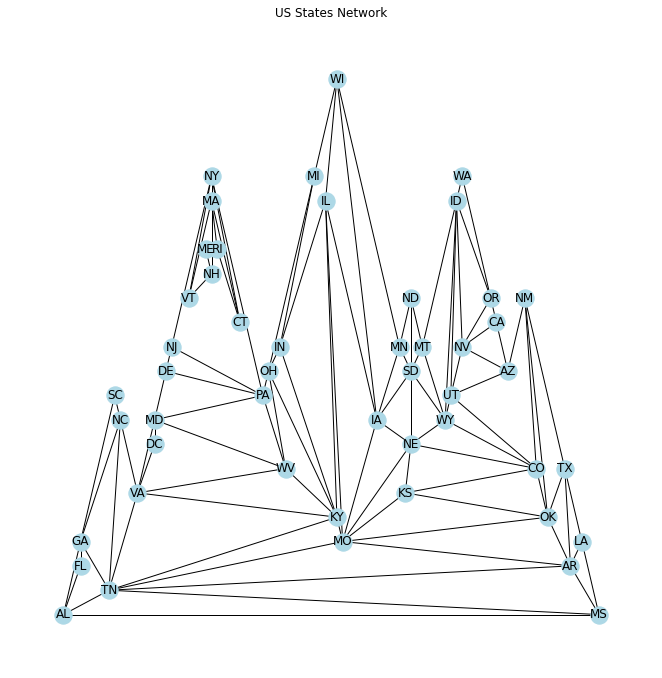

In [14]:
fig = plt.figure(figsize = (9, 9))
nx.draw_planar(states_graph, node_color = '#add8e6', with_labels = True)
plt.title('US States Network')
plt.show()
plt.close()

### Counties

#### Read counties data file

In [12]:
counties = pd.read_csv(os.getcwd() + '/Data/county_adjacency.csv')
counties.shape

(22200, 4)

In [13]:
counties.head()

,countyname,fipscounty,neighborname,fipsneighbor
0,"Autauga County, AL",1001,"Autauga County, AL",1001
1,"Autauga County, AL",1001,"Chilton County, AL",1021
2,"Autauga County, AL",1001,"Dallas County, AL",1047
3,"Autauga County, AL",1001,"Elmore County, AL",1051
4,"Autauga County, AL",1001,"Lowndes County, AL",1085


#### Preprocessing

Get states of counties

In [14]:
counties['county_state'] = counties['countyname'].apply(lambda x: x.split(',')[-1].strip())
counties['neighb_state'] = counties['neighborname'].apply(lambda x: x.split(',')[-1].strip())

counties.head()

,countyname,fipscounty,neighborname,fipsneighbor,county_state,neighb_state
0,"Autauga County, AL",1001,"Autauga County, AL",1001,AL,AL
1,"Autauga County, AL",1001,"Chilton County, AL",1021,AL,AL
2,"Autauga County, AL",1001,"Dallas County, AL",1047,AL,AL
3,"Autauga County, AL",1001,"Elmore County, AL",1051,AL,AL
4,"Autauga County, AL",1001,"Lowndes County, AL",1085,AL,AL


In [15]:
exclude = ['AK', 'HI', 'AS', 'GU', 'MP', 'PR', 'VI']

counties = counties[~counties['county_state'].isin(exclude)]
counties.shape

(21583, 6)

#### Create network of counties

In [16]:
counties_graph = nx.from_pandas_edgelist(counties, 'countyname', 'neighborname', ['county_state', 'neighb_state'])

In [17]:
counties_graph['Suffolk County, MA']

AtlasView({'Essex County, MA': {'county_state': 'MA', 'neighb_state': 'MA'}, 'Middlesex County, MA': {'county_state': 'MA', 'neighb_state': 'MA'}, 'Norfolk County, MA': {'county_state': 'MA', 'neighb_state': 'MA'}, 'Plymouth County, MA': {'county_state': 'MA', 'neighb_state': 'MA'}, 'Suffolk County, MA': {'county_state': 'MA', 'neighb_state': 'MA'}})

In [18]:
counties_graph.number_of_nodes(), counties_graph.number_of_edges()

(3109, 12354)

Remove self loops

In [19]:
counties_graph.remove_edges_from(nx.selfloop_edges(counties_graph))

counties_graph.number_of_nodes(), counties_graph.number_of_edges()

(3109, 9247)

In [20]:
counties_graph['Suffolk County, MA']

AtlasView({'Essex County, MA': {'county_state': 'MA', 'neighb_state': 'MA'}, 'Middlesex County, MA': {'county_state': 'MA', 'neighb_state': 'MA'}, 'Norfolk County, MA': {'county_state': 'MA', 'neighb_state': 'MA'}, 'Plymouth County, MA': {'county_state': 'MA', 'neighb_state': 'MA'}})

In [21]:
nx.write_gml(counties_graph, os.getcwd() + '/Graphs/counties_graph.gml')